# `SiFT` pipeline

This code presents the pipeline for running `SiFT` for filtering biological signals from single cell data.

We apply `SiFT` to remove cell cycle and sex signal, which add nuisance noise, in Drosophila wing disc development single cell data [[1]](https://doi.org/10.7554/eLife.61276).

We show that that conditioning on the gene expression from cell sex and cell cycle marker genes `SiFT` is able to deconfound cell sex and cell cycle effects while preserving signal from the other genes.

** NOTE: this analysis is inspired by the analysis provided in scvi-tools-reproducibility, [scvi_covariates.ipynb](https://yoseflab.github.io/scvi-tools-reproducibility/scvi_covariates/)

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

In [1]:
import numpy as np
import scanpy as sc

import sift

## Import data

download pre-processed data [drosopila.annotated.h5ad](https://drive.google.com/file/d/1onaka32WOxtUzk9fuRGO0E-Fb60KEoU5/view?usp=sharing)

In [2]:
DATA_DIR = ".../drosophila.annotated.h5ad"  # set path to anndata

In [3]:
adata = sc.read(DATA_DIR)

In [4]:
adata_ref = adata.copy()

We can visualize the data and observe the nuisance effect with respect to the `cell cycle`, `sex`,  `cc \& sex` labels. We also consider nuisance marker genea along-with a gene of interest:

* cell cycle marker: `PCNA`
* sex marker: `lncRNA:roX1`
* biological marker: `Nrt`

In [ ]:
sc.tl.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

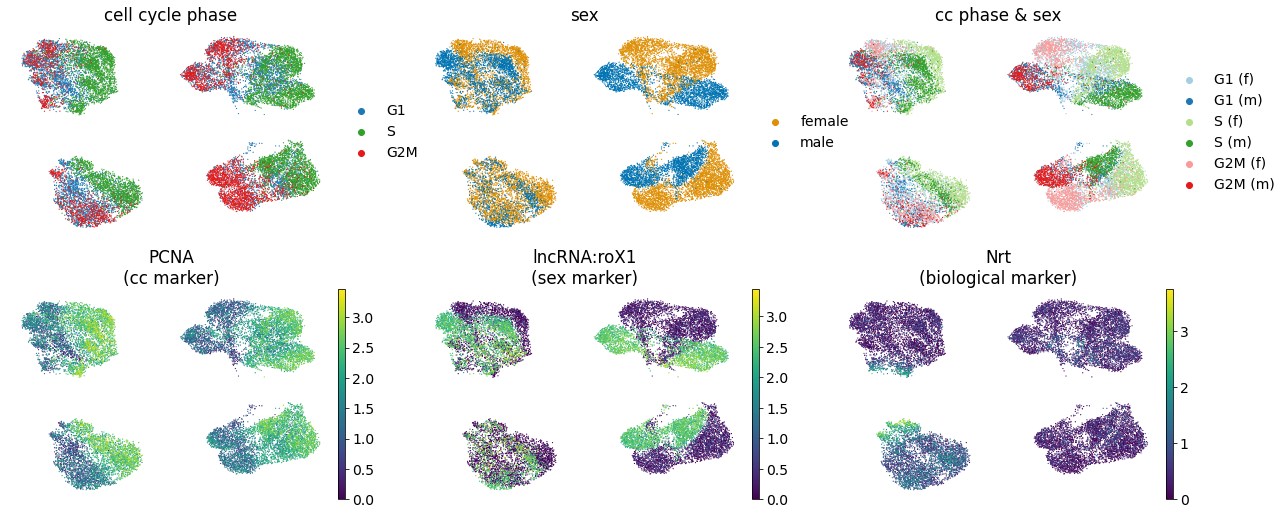

In [18]:
sc.pl.umap(
    adata_ref,
    color=["phase", "sex", "phase_sex", "PCNA", "lncRNA:roX1", "Nrt"],
    title=[
        "cell cycle phase",
        "sex",
        "cc phase & sex",
        "PCNA\n(cc marker)",
        "lncRNA:roX1\n(sex marker)",
        "Nrt\n(biological marker)",
    ],
    frameon=False,
    wspace=0.15,
    ncols=3,
)

## Apply `SiFT`

We set up `adata` for `SiFT` filtering based on nuisance genes,
copying the expression of the nuisance genes (`sex` and `cell_cycle` genes) into `adata.obsm`
and removing them from the expression data.

In [7]:
nuisance_genes = np.concatenate((adata.uns["sex_genes"], adata.uns["cell_cycle_genes"]))
adata.obsm["nuisance_genes"] = adata[:, nuisance_genes].X
adata.uns["nuisance_genes"] = nuisance_genes

gene_subset = [g for g in adata.var_names if g not in nuisance_genes]
adata = adata[:, gene_subset].copy()

### Set the parameters

* `metric`: the metric used for the SiFT kernel. Here we consider the _k-NN kernel_.
* `n_neighbors`:  for a _k-NN kernel_ we can specify the number of neighbors used.
* `kernel_key`: the `key` in the `anndata` used for defining the kernel.

In [8]:
metric_ = "knn"
n_neighbors_ = 5
kernel_key_ = "nuisance_genes"

### Define a `SiFT` object

Using `copy` we can specify if the `adata` object is modified in-place or copied.


In [9]:
sft = sift.SiFT(
    adata=adata,
    kernel_key=kernel_key_,
    n_neighbors=n_neighbors_,
    metric=metric_,
    copy=True,
)

INFO     sift: initialized a SiFTer with knn kernel.                                                               


We can visualize the kernel using `plot_kernel()`.

* `groupby`: the `key` in the `anndata` we can group the cells by.
* `color_palette`: colors for the `groupby` groups.

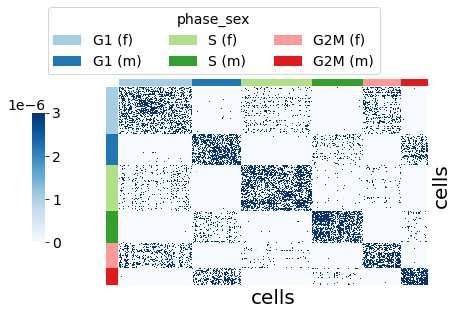

In [15]:
sft.plot_kernel(
    groupby="phase_sex", color_palette=adata.uns["phase_sex_colors"], ncol=3
)

### Perform filtering

To filter the object we use the `filter()` function.

* `embedding_key`: the `key` in the `anndata` for the data object we want to use.
* `pseudocount`: add a `pseudocount` to the filtered object to ensure non-negativity of `X`.

In [11]:
adata = sft.filter(embedding_key="X", pseudocount=False)

INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                


### Visualize the results

We observe the removal of the  nuisance effect with respect to the `cell cycle`, `sex`,  `cc \& sex` labels along-with the marker genes `PCNA` (cell cycle marker), and `lncRNA:roX1` (sex marker).

Further, for the biological marker gene, `Nrt`, we see a pattern is preserved.

In [12]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

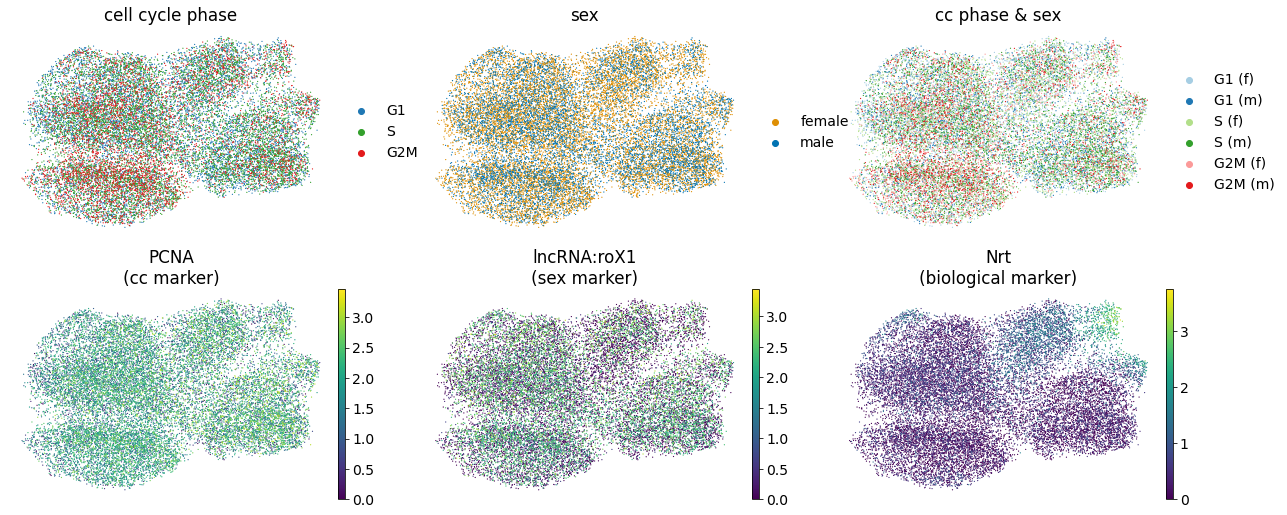

In [17]:
sc.pl.umap(
    adata,
    color=["phase", "sex", "phase_sex", "PCNA", "lncRNA:roX1", "Nrt"],
    title=[
        "cell cycle phase",
        "sex",
        "cc phase & sex",
        "PCNA\n(cc marker)",
        "lncRNA:roX1\n(sex marker)",
        "Nrt\n(biological marker)",
    ],
    frameon=False,
    wspace=0.15,
    ncols=3,
)